0.4990383642069035


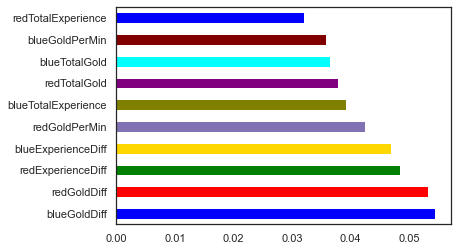

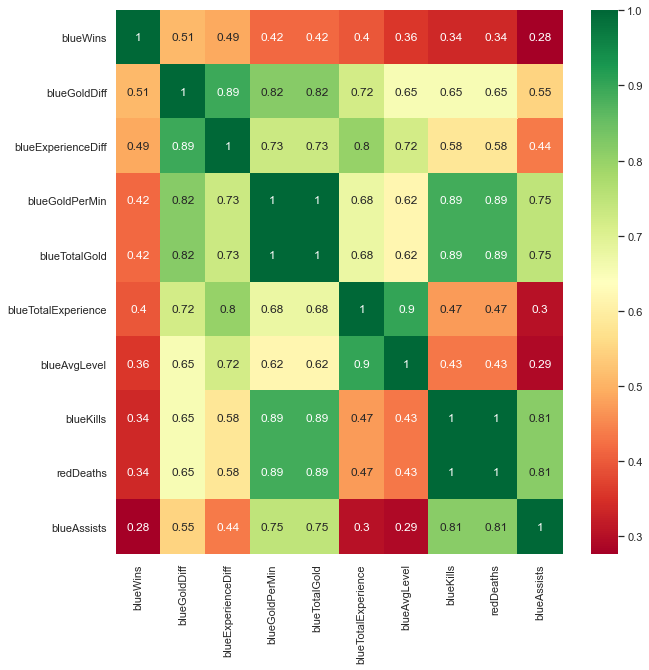

In [3]:
from Data_visualization.Feature_selection import FeatImp
from Data_cleanup.Cleanup import BlueRedSubstraction,Normalisation
from data_collect import detect_outliers
from Training.Training import cross_val_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



data = pd.read_csv('data/lol.csv') 
features = FeatImp(data)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")


sns.set(style='white', context='notebook', palette='deep')

'Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"\nfeaturov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare\ndil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'

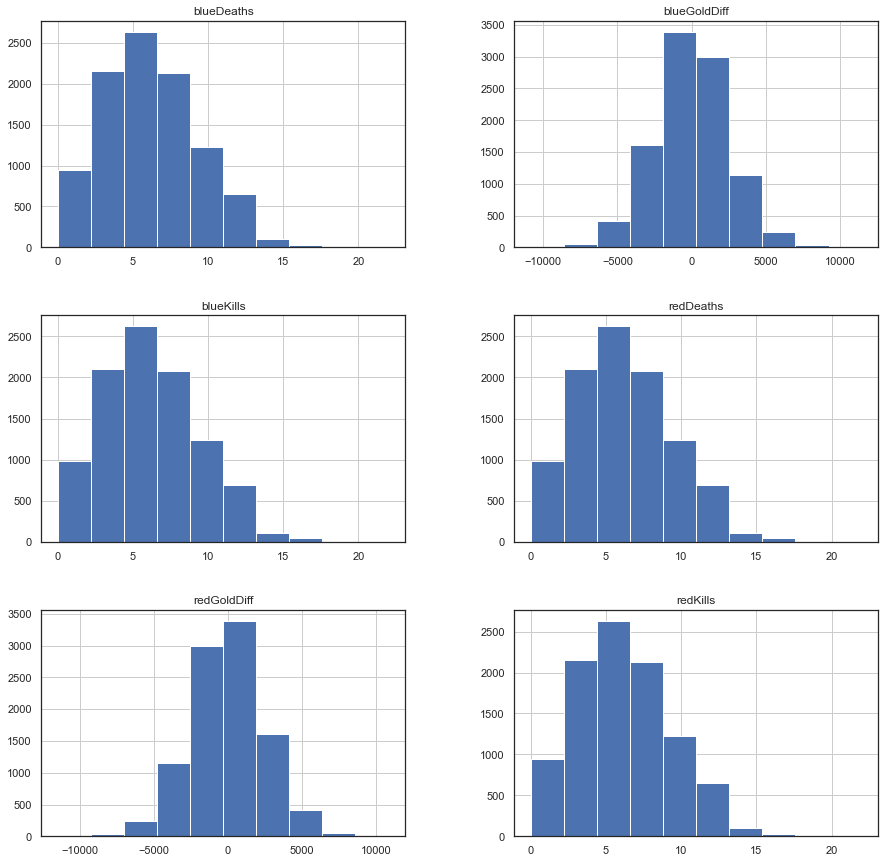

In [4]:
data[['blueKills',
 'redDeaths','redKills','blueDeaths',"blueGoldDiff",'redGoldDiff']].hist(figsize = (15,15))
data_0 = data.drop(['gameId'],axis = 1)
'''Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"
featurov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare
dil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'''

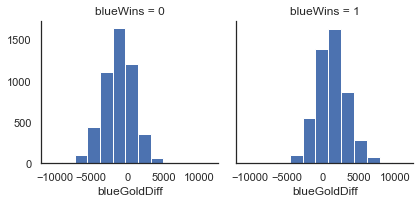

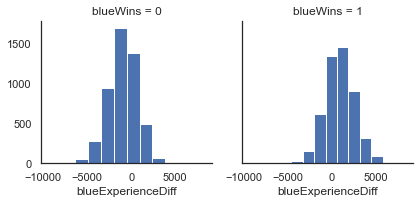

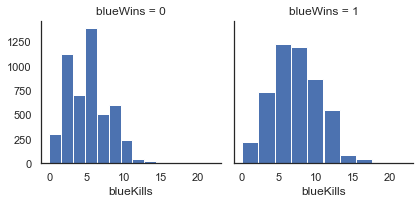

In [13]:
g = sns.FacetGrid(data_0, col='blueWins')
g = g.map(plt.hist,"blueGoldDiff")
g2 = sns.FacetGrid(data_0, col='blueWins')
g2 = g2.map(plt.hist,"blueExperienceDiff")
g3 = sns.FacetGrid(data_0, col='blueWins')
g2 = g3.map(plt.hist,"blueKills")

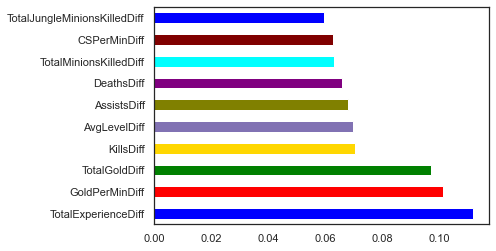

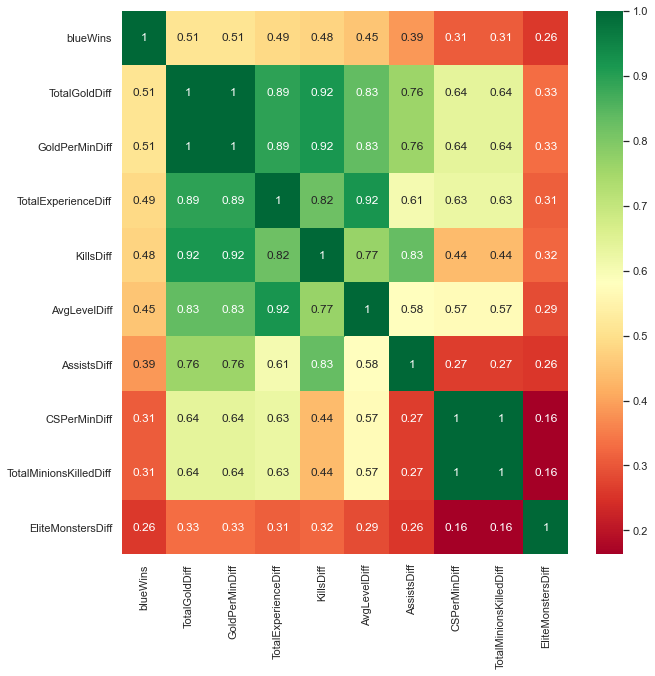

In [4]:
target = data['blueWins']
data_1 = BlueRedSubstraction(data) #spremenjeni podatki
data_2 = pd.concat([data_1,target],axis = 1)
features = FeatImp(data_2)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")
''' Opazim, da imata TotalGold ter GoldPerMin cisto iste korelacije, zato sem šel pogledat vrednosti stolpcev, ter ugotovil da se razlikujeta le
v enem faktorju. Mislim, da se lahko znebim featura GoldPerMin. Enako velja za CSPerMin.'''
data_3 = data_2.drop(["GoldPerMinDiff","blueWins","CSPerMinDiff"],axis = 1) # ovržem nekatere podobne stolpce,ter target stolpec


In [5]:
train_len = int(data_3.shape[0]*0.8)
train = data_3[:train_len]
test = data_3[train_len:]

target_train = target[:train_len]
target_test = target[train_len:]

,CrossValMeans,CrossValerrors,Algorithm
0,0.724786,0.010223,SVC
1,0.638494,0.010539,AdaBoost
2,0.717449,0.010973,RandomForest
3,0.709477,0.014132,ExtraTrees
4,0.680499,0.016361,KNeighboors
5,0.734277,0.013460,LogisticRegression


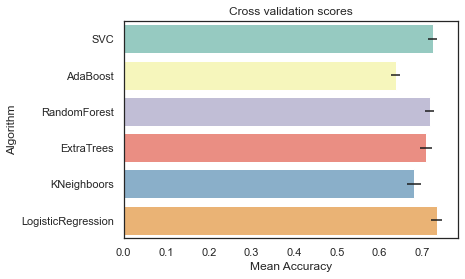

In [7]:
norm = Normalisation(MM = True)
train_sc, train_mm = norm.transform(X = train)
#data_sc standardna normalizacija
#data_mm  Min-Max normalizacija
#outliers = detect_outliers(train_sc,6,train_sc.columns.values)
#train_sc1 = train_sc.drop(outliers,axis = 0)
#target_train1 = target_train.drop(outliers,axis = 0)
cv_results = cross_val_results(train_sc,target_train)
cv_results

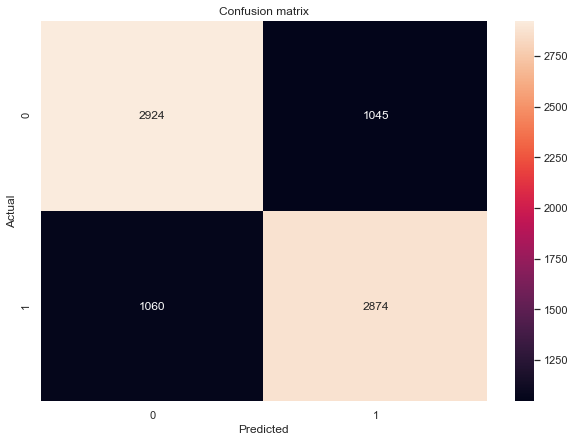

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
''' Zaradi najboljših rezultatov se osredotočim predvsem na model logistične regresije'''
LR = LogisticRegression()
y_pred = cross_val_predict(LR,train_sc,target_train,cv=3)
cm = confusion_matrix(target_train,y_pred)
plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
_ = ax.set_title('Confusion matrix')

In [13]:
'''Ali je kakšna pomembna razlika v false negatives in false positives?'''
Falses_dataset = pd.DataFrame({'validation':target_train,'predicted':y_pred})
Falses_dataset = pd.concat([Falses_dataset,train_sc], axis=1)
Falses_dataset.loc[Falses_dataset['validation'] == Falses_dataset['predicted'], "Equal"] = 'Equal'
Falses_dataset.loc[Falses_dataset['validation'] != Falses_dataset['predicted'], "Equal"] = 'Wrong'
Falses_dataset.drop(Falses_dataset[Falses_dataset.Equal != 'Wrong'].index, inplace=True)
Falses_dataset.loc[(Falses_dataset.validation == 0) & (Falses_dataset.predicted == 1), 'kind'] = 'FALSE POSITIVE'
Falses_dataset.loc[(Falses_dataset.validation == 1) & (Falses_dataset.predicted == 0), 'kind'] = 'FALSE NEGATIVE'
mask_fn = (Falses_dataset['kind'] == 'FALSE NEGATIVE')
mask_fp = (Falses_dataset['kind'] == 'FALSE POSITIVE')

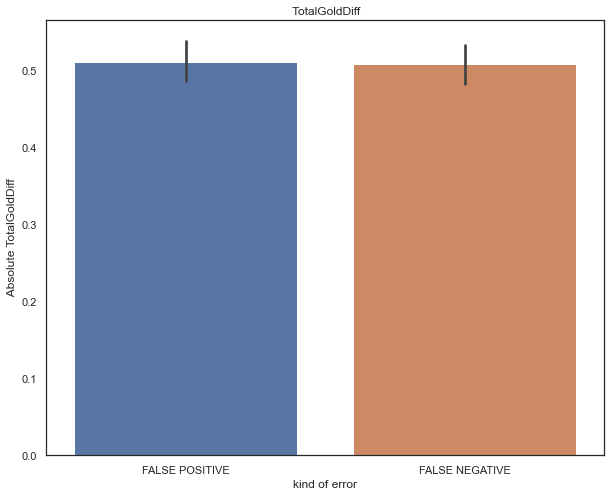

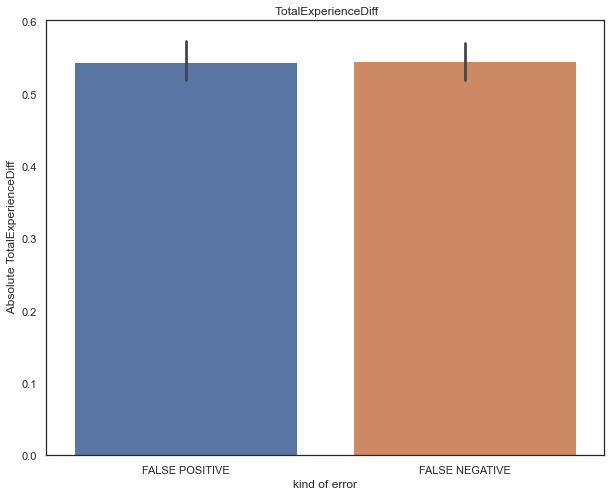

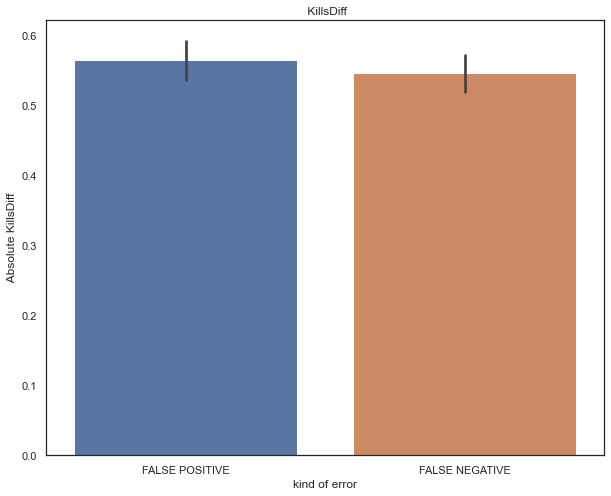

In [18]:

selected_columns = ['TotalGoldDiff', 'TotalExperienceDiff', 'KillsDiff']
for column in selected_columns:
    col_str = column.replace('red', '')   
    Falses_dataset[column] = Falses_dataset[column].map(abs)
    plt.figure(figsize=(10,8))
    ax = sns.barplot(x = 'kind', y =column, data=Falses_dataset)
    ax.set_ylabel(f' Absolute {col_str}')
    _ = ax.set_title(f' {col_str}')
    ax.set_xlabel('kind of error')
    plt.subplot(ax)

In [ ]:
'''Opazim, da bistvenih razlik v false positive ter false negative skoraj ni glede na tri najpomebnejše feature. Majhen porast false
positive opazimo pri feature KillsDiff, po katerem algoritem "sklepa", da tista ekipa ki do 10 minute doseže več Killov tudi zmaga,
ampak je potrebno potem to prednost tudi izkoristiti(kapitalizirati) z večjo razliko v Gold diff, kontroli mape,
ubijanju večjih Monsterov itd. '''